## Exploratory Data Analysis

In [52]:
# imports
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

We load three datasets, all recorded from the CWRU experiment @ 3 HP (~1730 RPM), recorded for approx. 10s using the Drive End accelerometer: 

- fault_12k: 0.021" ball fault time series sampled at 12kHz 
- fault_48k: 0.021" ball fault time series sampled at 48kHz
- normal_48k: Normal baseline time series sampled at 48kHz

In [114]:
# load data in 
fault_12k = pd.read_csv(r'C:\Users\User\Documents\COMPSCI 760\Bearing Fault Detection\data\processed\b021_3_12_DE.csv', header=None)
fault_48k = pd.read_csv(r'C:\Users\User\Documents\COMPSCI 760\Bearing Fault Detection\data\processed\b021_3_48_DE.csv', header=None)
normal_48k = pd.read_csv(r'C:\Users\User\Documents\COMPSCI 760\Bearing Fault Detection\data\processed\normal_3_48_DE.csv', header=None)

In [115]:
# rename columns and add time column 
fault_12k = fault_12k.rename(columns={0: 'accel'})
fault_48k = fault_48k.rename(columns={0: 'accel'})
normal_48k = normal_48k.rename(columns={0: 'accel'})

fault_12k['time'] = fault_12k.index
fault_48k['time'] = fault_48k.index
normal_48k['time'] = normal_48k.index

In [129]:
# define plotting function
def plot_ts(ts, title, dt):
    plt.plot(ts.index*dt, ts['accel'], label='sig')
    plt.xlabel('time (s)')
    plt.ylabel('accel ($m/s^2$)')
    plt.title(title)

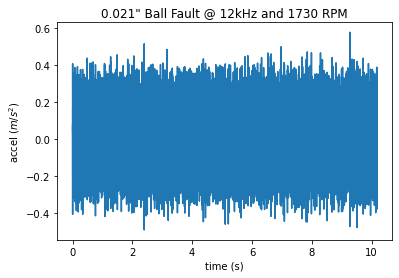

In [136]:
# plot time series
dt = 1/12000
plot_ts(fault_12k, '0.021" Ball Fault @ 12kHz and 1730 RPM', dt)

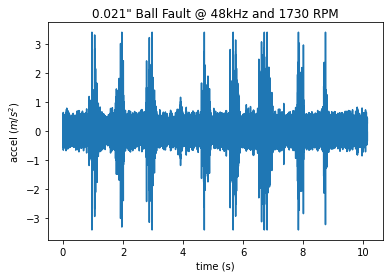

In [134]:
dt = 1/48000
plot_ts(fault_48k, '0.021" Ball Fault @ 48kHz and 1730 RPM', dt)

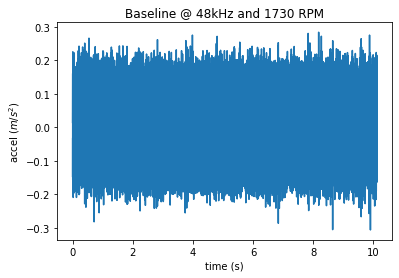

In [135]:
dt = 1/48000
plot_ts(normal_48k, 'Baseline @ 48kHz and 1730 RPM', dt)

In [139]:
# downsample 48k normal to approx. 12k
# normal_12k_val = signal.decimate(normal_48k.accel.values.T, 4)

In [308]:
normal_12k_val = normal_48k.accel.values[0::4]

In [309]:
normal_12k_val.shape

(121411,)

In [310]:
normal_12k = pd.DataFrame(normal_12k_val, columns=['accel'])
normal_12k['time'] = normal_12k.index

In [311]:
normal_12k

,accel,time
0,0.014603,0
1,0.112650,1
2,0.127670,2
3,0.046938,3
4,-0.000209,4
...,...,...
121406,-0.070929,121406
121407,-0.048816,121407
121408,0.016898,121408
121409,0.044435,121409


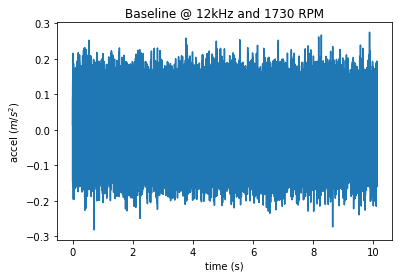

In [312]:
# plot time series
dt = 1/12000
plot_ts(normal_12k, 'Baseline @ 12kHz and 1730 RPM', dt)

<AxesSubplot:>

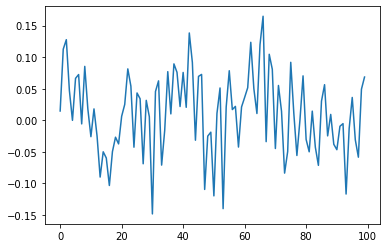

In [314]:
# plot first 100 points
normal_12k.accel[:100].plot()

<AxesSubplot:>

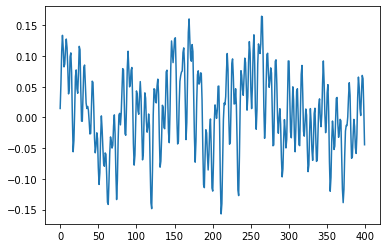

In [316]:
# plot first 400 points
normal_48k.accel[:400].plot()

In [317]:
# create new column assigning an individual id to windows of sizes corresponding to 1 rev 
normal_48k['id'] = np.array(normal_48k.index/1665, np.int32) 
fault_48k['id'] = np.array(fault_48k.index/1665, np.int32)
normal_12k['id'] = np.array(normal_12k.index/416, np.int32)
fault_12k['id'] = np.array(fault_12k.index/416, np.int32)

In [318]:
fault_48k

,accel,time,id
0,0.099301,0,0
1,0.066131,1,0
2,0.027120,2,0
3,-0.013143,3,0
4,-0.057578,4,0
...,...,...,...
486799,0.187130,486799,292
486800,0.142900,486800,292
486801,0.080526,486801,292
486802,0.004798,486802,292


## Extract Features

The extract_features function takes a while, so skip this section if already have preprocessed data files.

In [319]:
from tsfresh.feature_extraction import extract_features

# X_f48k = extract_features(fault_48k, column_id='id', column_sort='time')
# X_n48k = extract_features(normal_48k, column_id='id', column_sort='time')
# X_f12k = extract_features(fault_12k, column_id='id', column_sort='time')
# X_n12k = extract_features(normal_12k, column_id='id', column_sort='time')

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:45<00:00,  2.26s/it]


In [345]:
# X_f48k = pd.read_csv('X_f48k.csv').drop(columns=['Unnamed: 0'])
# X_n48k = pd.read_csv('X_n48k.csv').drop(columns=['Unnamed: 0'])
# X_f12k = pd.read_csv('X_f12k.csv').drop(columns=['Unnamed: 0'])
# X_n12k = pd.read_csv('X_n12k.csv').drop(columns=['Unnamed: 0'])

In [347]:
# X_f48k

In [348]:
X_48k = pd.concat([X_f48k, X_n48k], ignore_index=True)
X_12k = pd.concat([X_f12k, X_n12k], ignore_index=True)

In [349]:
y_48k = np.zeros((len(X_48k),1)) # create labels
y_48k[:len(X_f48k)] = '1'
y_48k[len(X_f48k):len(X_48k)] = '0'

In [350]:
y_12k = np.zeros((len(X_12k),1))
y_12k[:len(X_f12k)] = '1'
y_12k[len(X_f12k):len(X_48k)] = '0'

In [351]:
X_48k.shape

(585, 789)

In [352]:
X_48k_real = X_48k.dropna(axis=1) # drop columns with NaN
X_12k_real = X_12k.dropna(axis=1) # drop columns with NaN

In [353]:
from tsfresh.transformers import FeatureSelector

select = FeatureSelector() # we want to select only relevant features for prediction 

In [355]:
select.fit(X_48k_real, np.squeeze(y_48k))

FeatureSelector()

In [356]:
p_values = pd.Series(select.p_values, index=select.features)
p_values

accel__number_peaks__n_3                           1.715860e-97
accel__number_peaks__n_1                           2.088411e-97
accel__number_crossing_m__m_0                      2.694570e-97
accel__fourier_entropy__bins_10                    2.749926e-97
accel__ratio_value_number_to_time_series_length    2.909644e-97
                                                       ...     
accel__fft_coefficient__attr_"imag"__coeff_0                NaN
accel__fft_coefficient__attr_"angle"__coeff_0               NaN
accel__value_count__value_1                                 NaN
accel__value_count__value_-1                                NaN
accel__ratio_beyond_r_sigma__r_10                           NaN
Length: 788, dtype: float64

In [357]:
len(select.relevant_features)

309

In [358]:
X_48k_rel = select.transform(X_48k_real)
X_48k_rel.shape

(585, 309)

In [359]:
select.fit(X_12k_real, np.squeeze(y_12k))

FeatureSelector()

In [360]:
X_12k_rel = select.transform(X_12k_real)
X_12k_rel.shape

(586, 299)

In [361]:
X_48k_rel['label'] = np.int32(y_48k)
X_12k_rel['label'] = np.int32(y_12k)

In [362]:
X_48k_rel.to_csv('48k_proc.csv', index=False)
X_12k_rel.to_csv('12k_proc.csv', index=False)

## Fit Model on 12k dataset

In [363]:
# load in preprocessed data 
df_12k = pd.read_csv('12k_proc.csv')
df_48k = pd.read_csv('48k_proc.csv')

In [364]:
df_12k

,accel__has_duplicate,accel__ratio_value_number_to_time_series_length,accel__percentage_of_reoccurring_datapoints_to_all_datapoints,accel__percentage_of_reoccurring_values_to_all_values,accel__quantile__q_0.4,accel__quantile__q_0.8,accel__quantile__q_0.2,accel__quantile__q_0.7,accel__quantile__q_0.3,accel__quantile__q_0.9,...,accel__lempel_ziv_complexity__bins_100,accel__lempel_ziv_complexity__bins_3,"accel__fft_coefficient__attr_""angle""__coeff_81",accel__time_reversal_asymmetry_statistic__lag_1,accel__lempel_ziv_complexity__bins_10,accel__max_langevin_fixed_point__m_3__r_30,"accel__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)","accel__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""","accel__fft_coefficient__attr_""abs""__coeff_57",label
0,1.0,0.927885,0.139423,0.072539,-0.017543,0.093075,-0.106720,0.068060,-0.059695,0.161705,...,0.579327,0.209135,52.494338,1.857280e-04,0.358173,0.022129,0.019542,18.0,0.144301,1
1,1.0,0.918269,0.151442,0.075916,-0.026477,0.100220,-0.083492,0.061888,-0.052954,0.151550,...,0.579327,0.221154,45.825681,9.867026e-06,0.367788,0.596924,-0.042134,17.0,0.186510,1
2,1.0,0.913462,0.165865,0.086842,-0.023878,0.099898,-0.098761,0.065461,-0.056284,0.154235,...,0.579327,0.213942,76.274069,9.384885e-05,0.362981,0.051861,-0.034419,18.0,0.616713,1
3,1.0,0.918269,0.158654,0.083770,-0.027776,0.104120,-0.093075,0.060913,-0.058314,0.161625,...,0.564904,0.206731,45.867488,1.121850e-04,0.360577,0.006778,0.100469,17.0,0.441250,1
4,1.0,0.927885,0.141827,0.075130,-0.025015,0.099573,-0.086253,0.066761,-0.055471,0.137255,...,0.574519,0.201923,22.549382,1.141914e-05,0.355769,1.165951,0.017758,17.0,0.124602,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,0.0,1.000000,0.000000,0.000000,0.001236,0.057384,-0.029206,0.039039,-0.014951,0.078375,...,0.562500,0.206731,-141.653908,-2.438398e-06,0.341346,0.016695,0.061341,18.0,0.292314,0
582,0.0,1.000000,0.000000,0.000000,-0.001338,0.062094,-0.034751,0.045153,-0.018104,0.085732,...,0.579327,0.216346,40.436730,3.386318e-06,0.358173,0.021536,0.069268,18.0,0.364807,0
583,0.0,1.000000,0.000000,0.000000,-0.000247,0.065654,-0.030552,0.048142,-0.014643,0.090108,...,0.574519,0.225962,-83.992258,-6.068779e-07,0.358173,0.014455,0.081185,17.0,0.394002,0
584,0.0,1.000000,0.000000,0.000000,0.005144,0.058629,-0.028954,0.040697,-0.014091,0.084368,...,0.584135,0.216346,-50.258627,6.662942e-06,0.367788,0.676177,0.088236,17.0,0.364683,0


In [365]:
# separate dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_12k.iloc[:,0:-1], df_12k.iloc[:,-1], test_size=0.2)

In [375]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [376]:
clf.score(X_test, y_test)

1.0

In [377]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, clf.predict(X_test))

array([[48,  0],
       [ 0, 69]], dtype=int64)

[Text(0.5, 0.75, 'accel__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6 <= 0.002\ngini = 0.499\nsamples = 468\nvalue = [244, 224]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 244\nvalue = [244, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 224\nvalue = [0, 224]')]

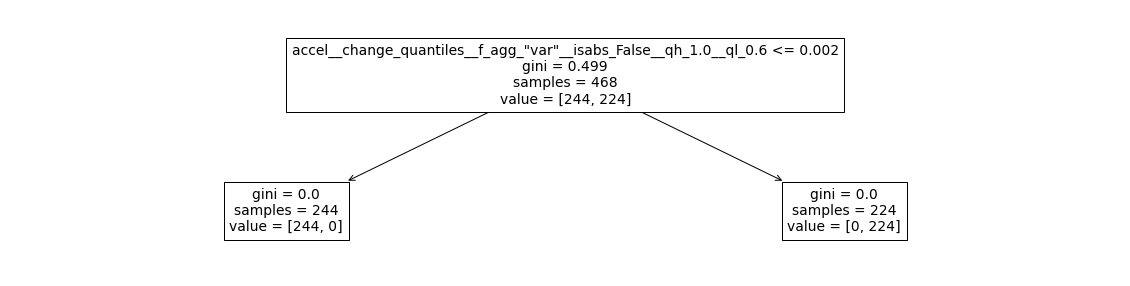

In [378]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 5))
plot_tree(clf, feature_names=X_train.columns)

## Try with minimal feature set

In [379]:
# extract minimal feature set
from tsfresh.feature_extraction.settings import MinimalFCParameters

minimal_fc = MinimalFCParameters()  # Create dictionary
minimal = sorted(minimal_fc.keys())  # Sort list of dictionary keys
print('Number of feature calculators: ', len(minimal))
print(minimal)

Number of feature calculators:  10
['absolute_maximum', 'length', 'maximum', 'mean', 'median', 'minimum', 'root_mean_square', 'standard_deviation', 'sum_values', 'variance']


In [380]:
X_f12k = extract_features(fault_12k, column_id='id', column_sort='time',
                    default_fc_parameters=minimal_fc)
X_n12k = extract_features(normal_12k, column_id='id', column_sort='time',
                    default_fc_parameters=minimal_fc)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.90it/s]


In [382]:
X_12k = pd.concat([X_f12k, X_n12k], ignore_index=True)
X_12k_real = X_12k.dropna(axis=1) # drop columns with NaN

In [384]:
select.fit(X_12k_real, np.squeeze(y_12k))

FeatureSelector()

In [385]:
X_12k_rel = select.transform(X_12k_real)
X_12k_rel.shape

(586, 9)

In [388]:
X_12k_rel['label'] = np.int32(y_12k)
X_12k_rel.to_csv('12k_proc_min.csv', index=False)

In [390]:
df_12k_min = pd.read_csv('12k_proc_min.csv')

In [391]:
X_train, X_test, y_train, y_test = train_test_split(df_12k_min.iloc[:,0:-1], df_12k_min.iloc[:,-1], test_size=0.2)

In [393]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0

[Text(0.5, 0.75, 'accel__root_mean_square <= 0.085\ngini = 0.5\nsamples = 468\nvalue = [235, 233]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 235\nvalue = [235, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 233\nvalue = [0, 233]')]

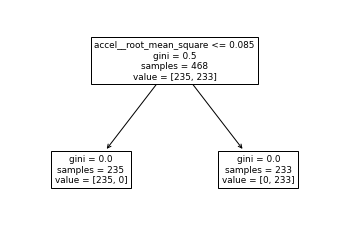

In [394]:
plot_tree(clf, feature_names=X_train.columns)